In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import mglearn as mg
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler , LabelEncoder , OrdinalEncoder  
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
from sklearn.model_selection import train_test_split , KFold , cross_val_score , GridSearchCV
from sklearn.linear_model import Lasso , LogisticRegression
from sklearn.metrics import mean_squared_error
# import seaborn as sb
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats

0: reading the data

In [2]:
aisles = pd.read_csv(r"archive\aisles.csv")
department = pd.read_csv(r"archive\departments.csv")
pro_prior = pd.read_csv(r"archive\order_products__prior.csv")
pro_train = pd.read_csv(r"archive/order_products__train.csv")
orders = pd.read_csv(r"archive\orders.csv")
products = pd.read_csv(r"archive\products.csv")

1: Joins and memory optimization

In [3]:
def reduce_memory(df):

    for col in df.columns:
        col_type = df[col].dtype

        if "int" in str(col_type):                 #السترينق حطيتها لانه برجع np.dtype ف لازم نحولها لنوعها المنطقي عشان نقدر نعمل مقارنه
            df[col] = df[col].astype("int32")

        elif "float" in str(col_type):
            df[col] = df[col].astype("float32")

        #بالبدايه حطيت بس else بعدين اكتشفت انه في انواع بيانات ثانيه مثل bool
        elif col_type == "object":
            df[col] = df[col].astype("category")

    return df

In [4]:

dfs = [aisles , department , pro_prior , pro_train , orders , products]

for i in range(len(dfs)):
    dfs[i] = reduce_memory(dfs[i])

In [5]:
#   في m1 
#   pro_prior بلشنا ب هذول لانه يحتوي تفاصيل المنتجات داخل الطلبات
#   orders هو اللي بحتوي على معلومات الطلب , المستخدم , الوقت
m1 = pd.merge(pro_prior , orders , on = "order_id" , how = "left")
m2 = pd.merge(m1 , products , on = "product_id" , how = "left")
m3 = pd.merge(m2 , department , on = "department_id" , how = "left")
Full_DataSet = pd.merge(m3 , aisles , on = "aisle_id" , how = "left")

In [6]:
print(Full_DataSet.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   product_id              int32   
 2   add_to_cart_order       int32   
 3   reordered               int32   
 4   user_id                 int32   
 5   eval_set                category
 6   order_number            int32   
 7   order_dow               int32   
 8   order_hour_of_day       int32   
 9   days_since_prior_order  float32 
 10  product_name            category
 11  aisle_id                int32   
 12  department_id           int32   
 13  department              category
 14  aisle                   category
dtypes: category(4), float32(1), int32(10)
memory usage: 1.6 GB
None


In [186]:
#كنت بدي اصير اعمل قراءه للملف مره ثانيه عشان ما اضل اعمل دمج كل ما اشغل الكود , بس اكتشفت انه تحميله بقعد وقت اكثر
#Full_DataSet.to_csv('archive/full_instacart_data.csv', index=False)

2: EDA

days_since_prior_order    2078068
dtype: int64
Percentage of missing values in columns
 days_since_prior_order    6.40697
dtype: float64


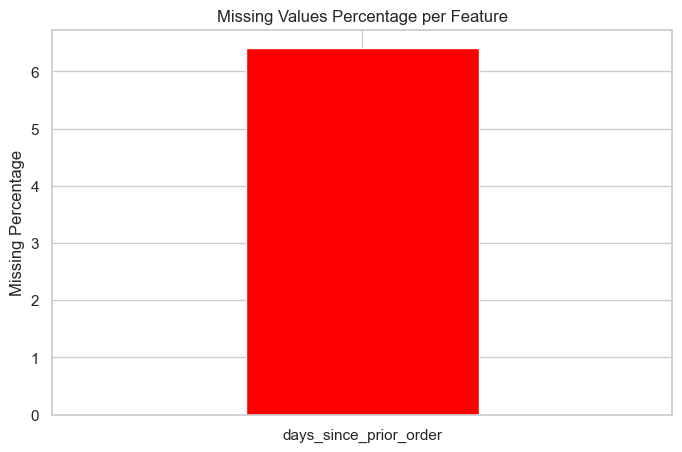

In [ ]:
#cheking for null values
missing_values = Full_DataSet.isnull().sum()
missing_values = missing_values[missing_values > 0]
print( missing_values )
print("=="*40 )
missing_percent = (missing_values / len(Full_DataSet)) * 100
print(f"Percentage of missing values in columns\n {missing_percent}", )

missing_percent.plot(kind='bar', figsize=(8, 5), width=0.3, color='red', rot=0)
plt.ylabel("Missing Percentage")
plt.title("Missing Values Percentage per Feature")
plt.show()
# هاي مش قيم مفقوده بالغلط هاي بتدل انه الزبون اول مره بيطلب فمفيش عندو قيمه ل days_since_prior_order

Distribution plots for numeric features and target(s) (histogram, density).


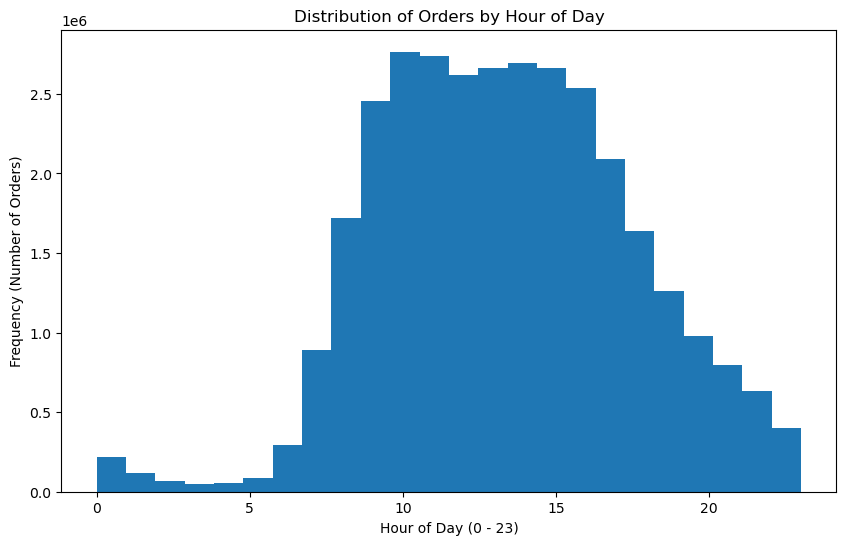

In [188]:
# لازم نختار الاعمده الرقميه الي الها معنى او بتفيدنا لو عملنا الها هستوغرام او دينستي بالاحرى مين مهم افهم الديستربويشن تبعو
Full_DataSet['order_hour_of_day'].plot(kind='hist', bins=24, figsize=(10, 6), title='Distribution of Orders by Hour of Day')

#Histogram (المدرج التكراري) رسمة أعمدة بتبين الكمية في كل فترة

plt.xlabel('Hour of Day (0 - 23)') # سمينا المحور عشان الدكتور يفهم

plt.ylabel('Frequency (Number of Orders)')
plt.show()

#بنلاحظ  فوق الوقت الي بكون فيه وقت الذروه للزباين متى بكون باليوم 

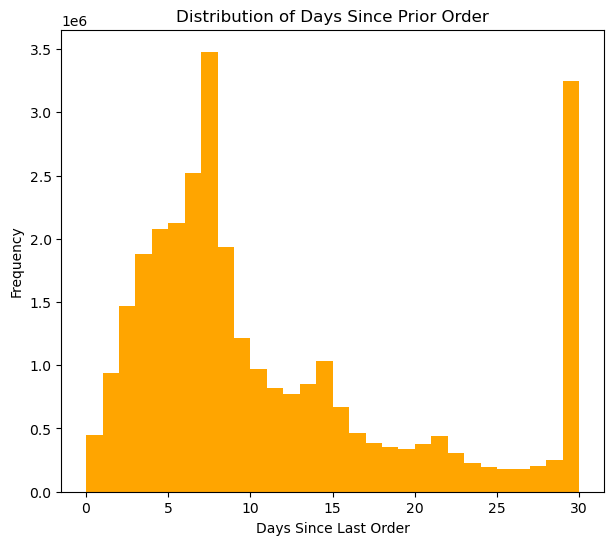

In [189]:
Full_DataSet['days_since_prior_order'].plot(kind='hist', bins=30, figsize=(7, 6), color='orange', title='Distribution of Days Since Prior Order')

plt.xlabel('Days Since Last Order')
plt.ylabel('Frequency')
plt.show()

In [190]:
#Weekly shoppers (peak at 7 days) and Monthly shoppers (peak at 30 days). The spike at 30 days also includes customers who haven't ordered for more than a month

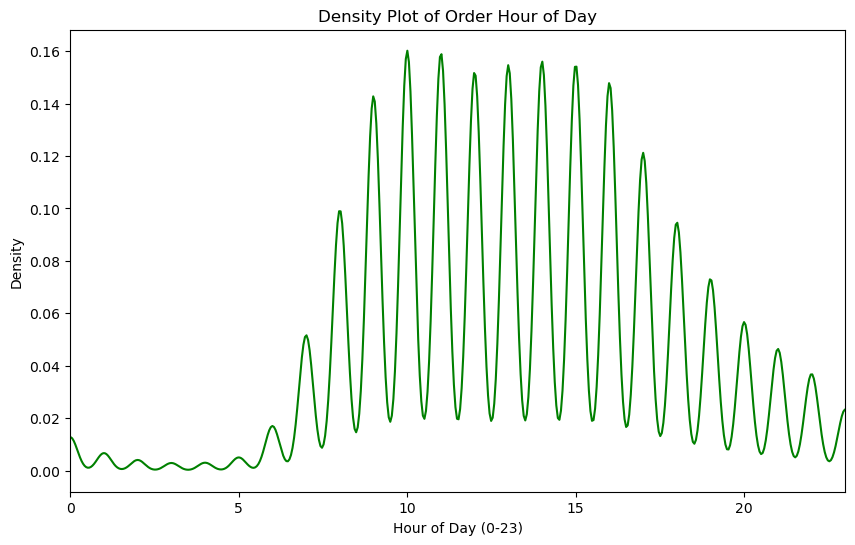

In [191]:
# 1. نأخذ عينة عشوائية (10% مثلاً) عشان الرام ما تنفجر
# هذا العمود يمثل "ساعات اليوم" من 0 لـ 23
sample_hours = Full_DataSet['order_hour_of_day'].sample(frac=0.1, random_state=42)

# 2. الرسم


plt.figure(figsize=(10, 6))

sample_hours.plot(kind='kde', color='green', title='Density Plot of Order Hour of Day')

plt.xlabel('Hour of Day (0-23)')
plt.xlim(0, 23) # عشان نحصر الرسمة في حدود اليوم
plt.show()

#الدينستي بعطينا هون تفاصيل اكثر او معبر اكثر بس بوخذ وقت اكثر للامانه 


Categorical cardinality analysis (barplots / top-k frequencies).

In [14]:
# first we need to do some cardinality checking for the catorgorical features
categorical_cols = Full_DataSet.select_dtypes(include=['category']).columns
categorical_cols



Index(['eval_set', 'product_name', 'department', 'aisle'], dtype='object')

In [ ]:
Full_DataSet["product_name"].value_counts() # هون بنلاحظ انو في منتجات كتير متكرره يعني الكارديناليتي عاليه فهاض العامود مابفيدني اعملو فيجواليزشن

product_name
Banana                                    472565
Bag of Organic Bananas                    379450
Organic Strawberries                      264683
Organic Baby Spinach                      241921
Organic Hass Avocado                      213584
                                           ...  
Unpeeled Apricot Halves in Heavy Syrup         0
12 Inch Taper Candle White                     0
Non-Dairy Coconut Seven Layer Bar              0
Pure Squeezed  Lemonade                        0
Protein Granola Apple Crisp                    0
Name: count, Length: 49688, dtype: int64

In [20]:
# نعمل فحص للباقي 
checking = ['department', 'aisle', 'product_name']

cardinality_counts = Full_DataSet[checking].nunique()
print("عدد الأنواع في كل عمود")
print(cardinality_counts)
# هون بنلاحظ الديبراتمنت فيه تنوع واطي فا بنقدر نعملو فيجواليز ونستفيد منه 
# الممرات 134 يعتبر عاللي فامبنقدر نرسمو كلو رح نوخذ الاكثر تكرارا تمام نفس الحاله بنطبقها على اسماء المنتجات

عدد الأنواع في كل عمود
department         21
aisle             134
product_name    49677
dtype: int64


In [ ]:
# what is eval_set refer to ? 
Full_DataSet['eval_set'].value_counts()
# هون شفنا انو هاض العامود بحتوي على داتا بتمثل الطلبات القديمه فهاض الاشي مابفيدني اني اعملو فيجواليز 

eval_set
prior    32434489
test            0
train           0
Name: count, dtype: int64

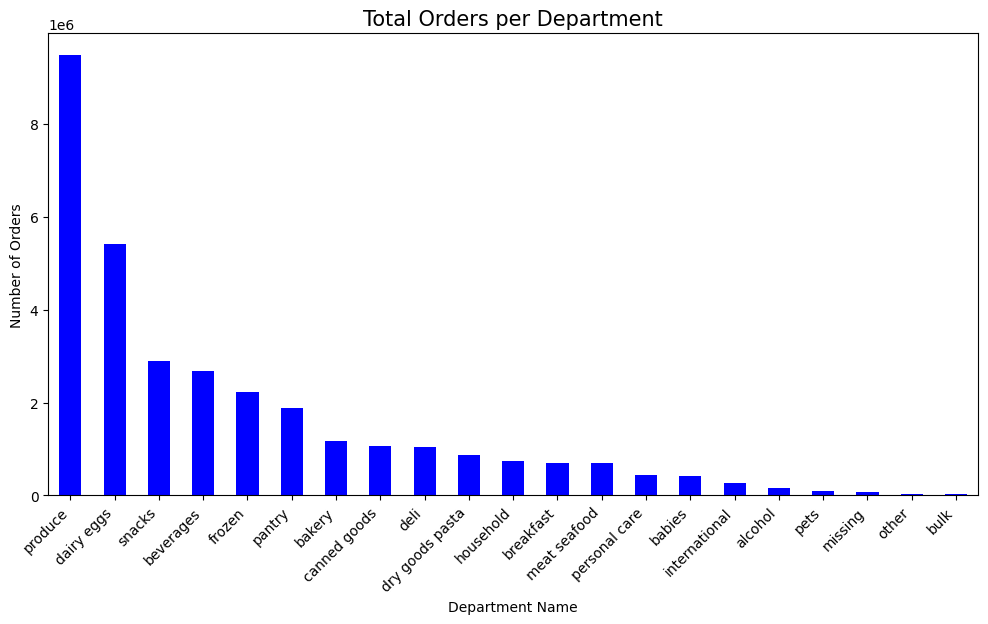

In [ ]:


#  بنرسمه كأعمدة Barplot
Full_DataSet['department'].value_counts().plot(kind='bar', figsize=(12,6) , color='blue')

plt.title('Total Orders per Department', fontsize=15)
plt.ylabel('Number of Orders')
plt.xlabel('Department Name')
plt.xticks(rotation=45, ha='right') # ميلنا الأسماء عشان نقرأها بوضوح
plt.show()

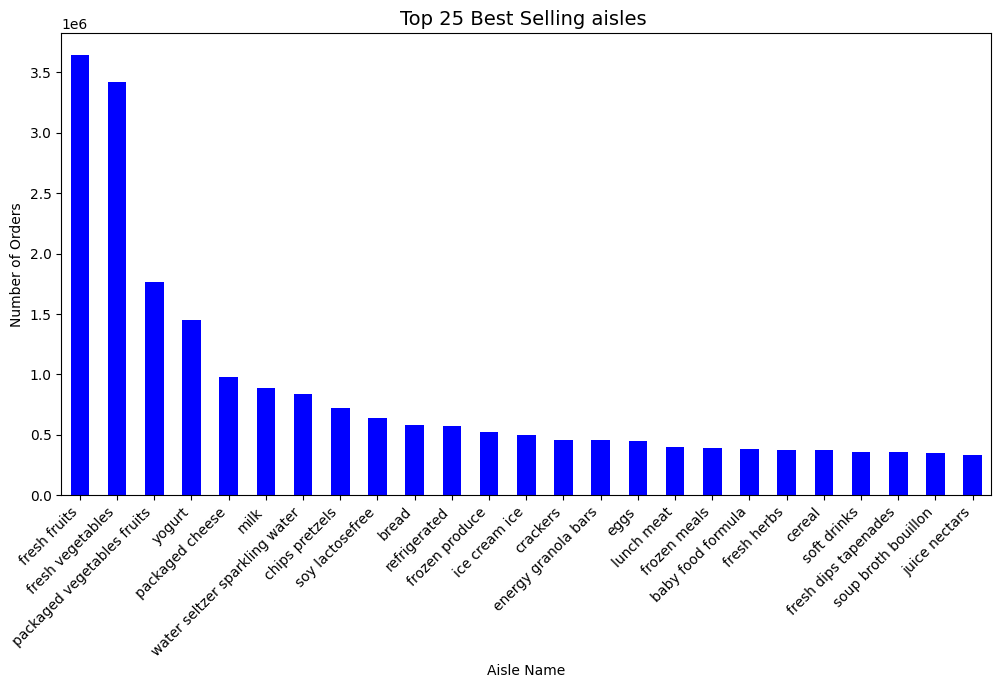

In [ ]:
top_aisles = Full_DataSet['aisle'].value_counts().head(25)
#  هون ممكن تسالني انت طيب كيف رتبتهم من الاكثر للاقل ؟ لان الميثود تاعت الفاليوز بالديفولت تاعها بترتبهم من الاكبر لاصغبر 

top_aisles.plot(kind='bar',figsize=(12, 6), color='blue')


plt.title('Top 25 Best Selling aisles ', fontsize=14)
plt.ylabel('Number of Orders')
plt.xlabel('Aisle Name')
plt.xticks(rotation=45, ha='right') # ميلنا الكلام بزاوية 45 عشان ينقرأ بوضوح
plt.show()

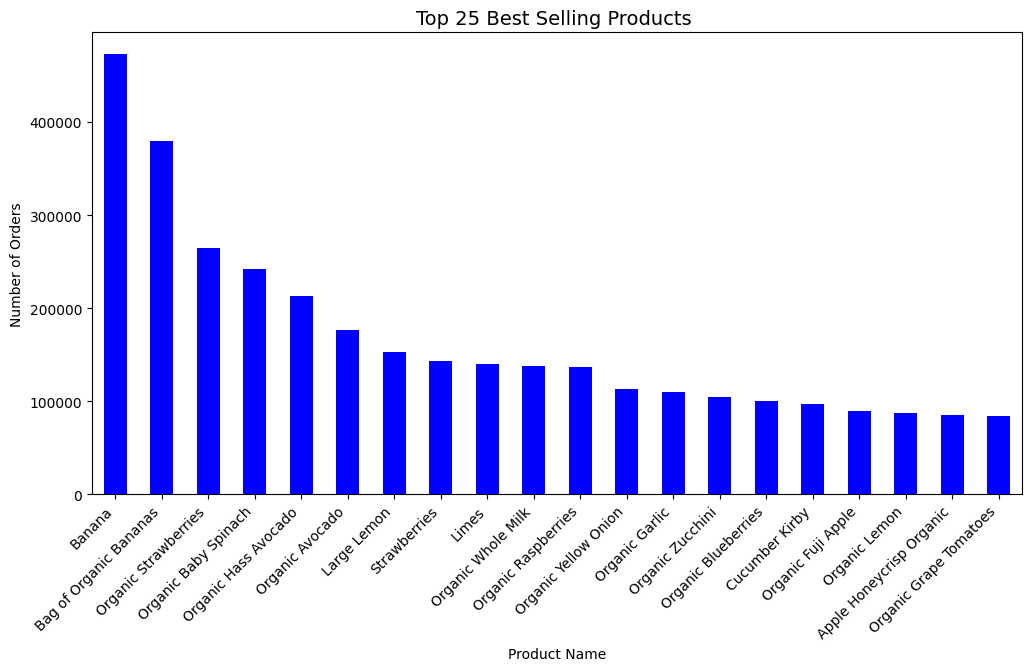

In [ ]:
products_for_visuals = Full_DataSet['product_name'].value_counts().head(20) # هون اخذنا اكثر 20 بس عشان يصير مقروء بشكل احسن 

products_for_visuals.plot(kind='bar', figsize=(12, 6), color='blue')
plt.title('Top 25 Best Selling Products ', fontsize=14)
plt.ylabel('Number of Orders')  
plt.xlabel('Product Name')
plt.xticks(rotation=45, ha='right')
plt.show()

• Correlation matrix, heatmap and pairwise scatter plots for selected numeric features.

In [ ]:
#  هاي الخطوة بدنا نعرف شو العوامل اللي بتخلي الزبون يعمل اعادة طلب او reorder
# في هاي الحاله لازم نختار الاعمده الرقميه الي الها سلوك او بمعنى اصح الها معنى 

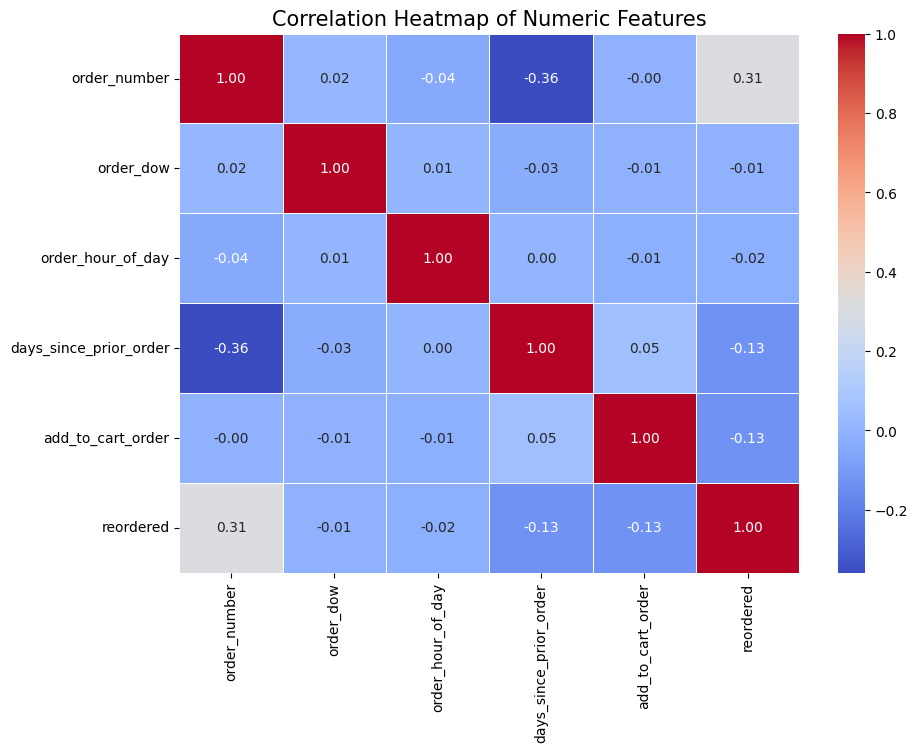

In [38]:
selected_features = [
    'order_number',
    'order_dow', 
    'order_hour_of_day', 
    'days_since_prior_order', 
    'add_to_cart_order', 
    'reordered' # هاض العامود الي بدنا نعرف شو العوامل الي بتأثر عليه مثل ماقلنا فوق 
]

# 2. حساب المصفوفة (Correlation Matrix)
# الدالة .corr() هي العقل المدبر اللي بيحسب العلاقات
corr_matrix = Full_DataSet[selected_features].corr()


# annot=True: عشان يكتب الرقم جوا المربع
# cmap='coolwarm': ألوان (أحمر للحار/الموجب، أزرق للبارد/السالب)
# fmt='.2f': منزلتين عشريتين بس
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=False)

plt.title('Correlation Heatmap of Numeric Features', fontsize=15)
plt.show()

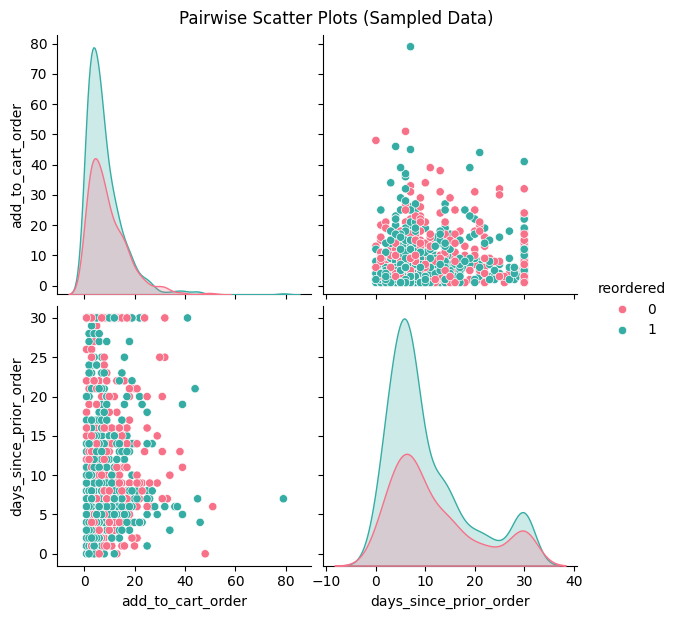

In [ ]:
# 1. نأخذ عينة صغيرة جداً (1000 سطر) عشان الرسم يكون خفيف وواضح
# Scatter Plot بيموت لو الداتا كبيرة
scatter_sample = Full_DataSet.sample(n=1000, random_state=42)

# 2. تحديد الأعمدة اللي بدنا نشوف علاقتها ببعض
# ركزنا على أهم 3 أعمدة عشان ما نضيع وقت
cols_to_plot = ['add_to_cart_order', 'days_since_prior_order', 'reordered']

# 3. رسم الـ Pairplot
# hue='reordered': عشان يلون النقاط (برتقالي للمكرر، أزرق للجديد)
sns.pairplot(scatter_sample[cols_to_plot], hue='reordered', palette='husl', height=3)

plt.suptitle('Pairwise Scatter Plots ', y=1.02)
plt.show()


In [ ]:
#طيب اللون الاخضر هون بمثل المنتجات المعاد شرائها بنلاحظ بالرسمه انو دايما بالبدايه ببدا الزبون يجيب اغراضو الي  متعود عليها
#بعدين بعد ما يجيبهم بجيب او بجرب اغراض جديده  مثل مابثمل اللون الزهري الي بمثل الاشياء الجديده
#الرسمة الشمال تحت النقط بتوريك إن المنتجات المكررة الخضراء دايما محجوز الها المقاعد الأولى بالسلة  بغض النظر عن كم يوم مر.

# الرسمة اليمين جبال بتأكد إن الناس بتتسوق بنظام أسبوعي أو شهري والمنتجات الجديدة والقديمة بتمشي على نفس هذا النظام.

• Time-of-day, day-of-week, and monthly seasonality plots

In [12]:
hourrr=Full_DataSet['order_hour_of_day'].value_counts()
hourrr

order_hour_of_day
10    2764426
11    2738582
14    2691548
15    2664533
13    2663292
12    2620847
16    2537458
9     2456713
17    2089465
8     1719973
18    1637923
19    1259401
20     977038
7      891937
21     796370
22     634734
23     402620
6      290795
0      218948
1      115786
5       88062
2       69434
4       53283
3       51321
Name: count, dtype: int64

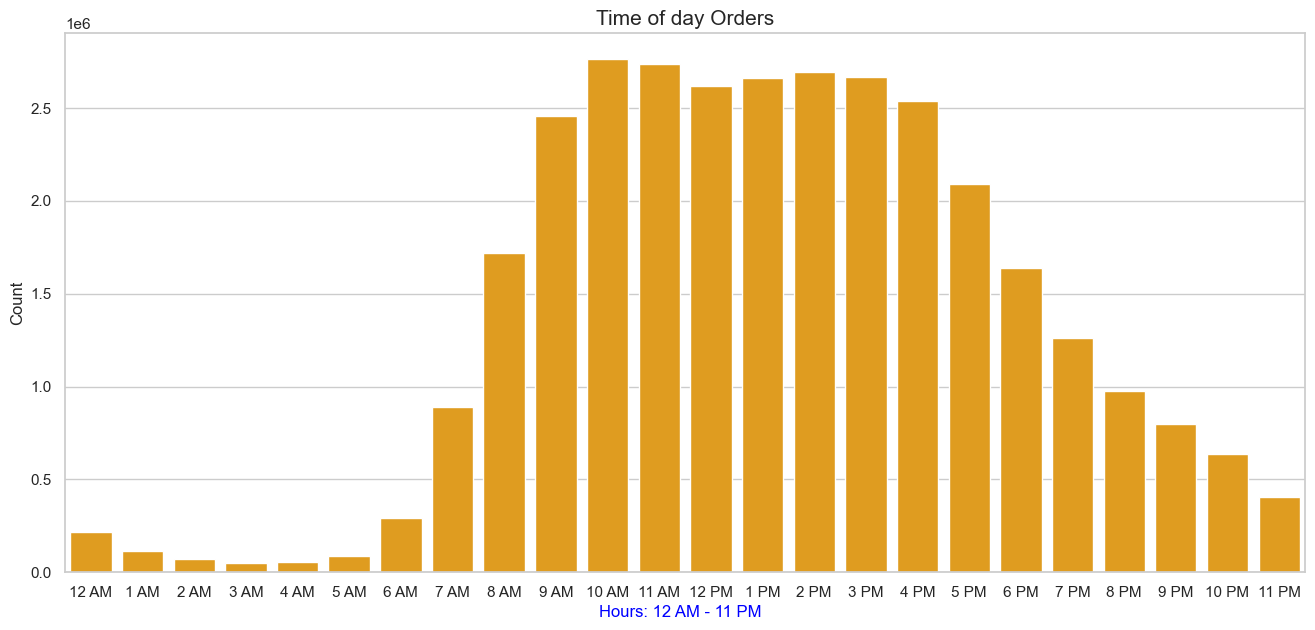

In [27]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 7))


# هون لازم قبل مانرسم نجهز الداتا لانها عباره عن مليون سطر فا لازم نرتبها اول حسب التكرار بعدين بنرتبها حسب الاندكس تصاعدني 
hour_counts = Full_DataSet['order_hour_of_day'].value_counts().sort_index()
#لو تركناها هيك لاحظت رح تطلع معنا الرسمه الساعات من صفر ل 23 فا حيكون شوي مش مقروء الوضع فا افترحت لو بدنا نوري هالرسمه لاي حد لو نزبط الاندكس
#ونخليه بنظام am و pm 
#بكون احسن ليش فقط عشان نخليه مقروء واريح للعين اكثر 
labels_of_hours = [
    "12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM", 
    "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM",
    "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM", 
    "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"
]
# x=labels_of_hours (الساعات)
# y=hour_counts.values (عدد الطلبات)
#هون اخترنا بار بلوت عشان سريع وبرضو برسملنا ال 24 عمود بسرعه عاليه
sns.barplot(x=labels_of_hours, y=hour_counts.values, color='orange',)

plt.title('Time of day Orders', fontsize=15)
plt.xlabel('Hours: 12 AM - 11 PM  ', fontsize=12,color='blue') 
plt.ylabel('Count', fontsize=12)
plt.show()

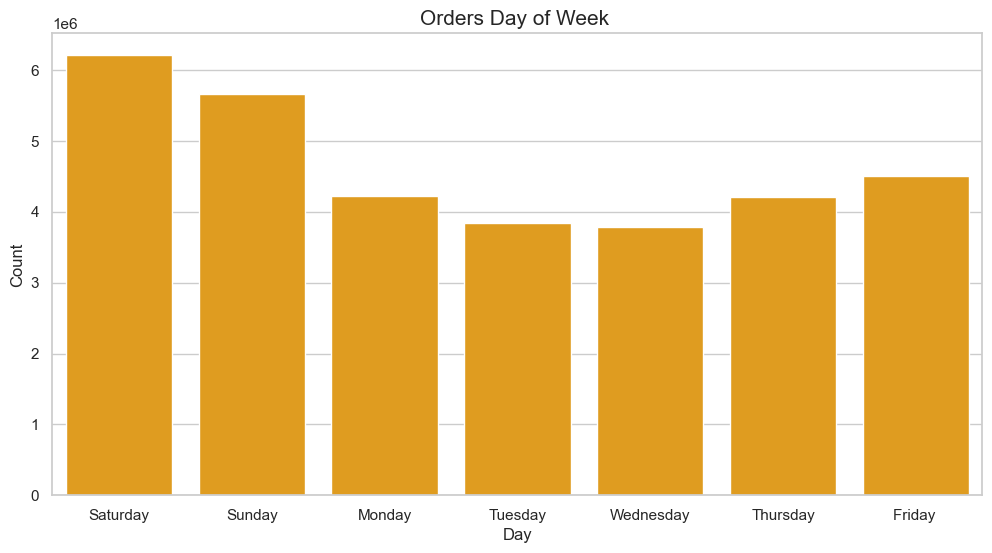

In [30]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# رح يطلع معنا 7 أرقام من 0 ـ 6
day_counts = Full_DataSet['order_dow'].value_counts().sort_index()

#بنرتبهم كمان مره زي ماعملنا فوق 
 # الويك إند عند الاجانب ببدا من السبت فهو رح يكون رقم صفر
days_labels = ["Saturday",  "Sunday", "Monday",  "Tuesday", "Wednesday", "Thursday","Friday "]



sns.barplot(x=days_labels, y=day_counts.values, color="orange")

plt.title('Orders Day of Week ', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)

plt.show()
#بنلاحظ انو بالويكند اعلى طلبات وهاض المنطقي لانو الناس بتكون معطله

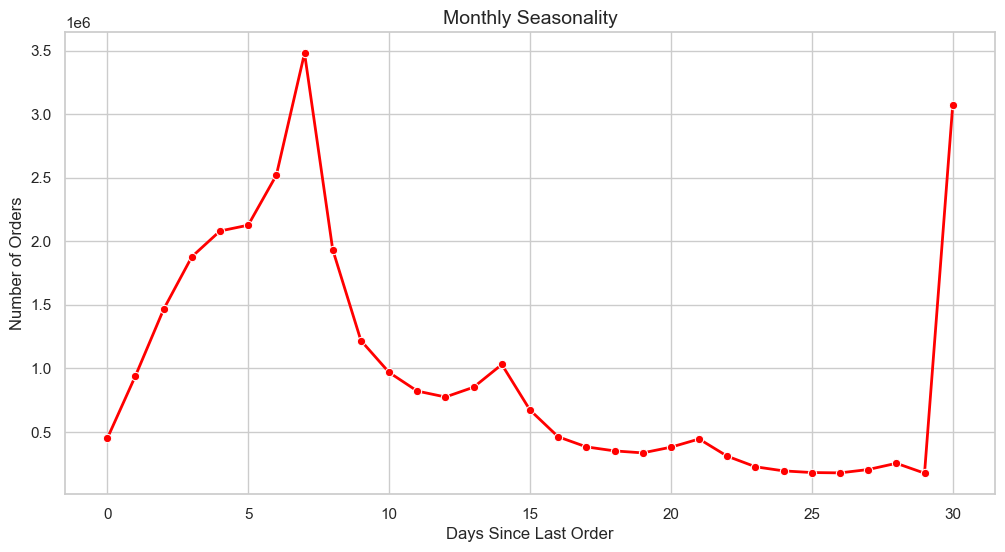

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

#  هون رح نستخدم هاض الكولوم لانو انسب اشي للمنثلي لانو مافي عنا بالداتا سيت كولم عن الاشهر
days_of_month_counts = Full_DataSet['days_since_prior_order'].value_counts().sort_index()
#رح نستخدم اللاين بلوت عشان نوضح التغيرات بشكل افضل
sns.lineplot(x=days_of_month_counts.index, y=days_of_month_counts.values, marker='o', color='red', linewidth=2)

# 3. تحسين المحاور
plt.title('Monthly Seasonality', fontsize=14)
plt.xlabel('Days Since Last Order', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()
#بنلاحظ في قمه عند ال 7 و 30 يوم هاض يعني انو الزبون كل اسبوع غالبا بيجي يشتري وفي زباين بتيجي كل شهر او اكثر من شهر هاض كلو بنحط عند ال 30 

3+4+5: cleaning , preprocessing and scaling


In [7]:
del Full_DataSet["aisle"]
del Full_DataSet["department"]
del Full_DataSet["eval_set"]
 
print(Full_DataSet.isnull().sum())
print("---------------------------------------")

#كان هدفي اشوف ال نان من هون بس ما زبطت ف شفتها من الملف نفسه
Full_DataSet.head(10)
#اللي بين معي انه ال نان بكون موجود لكل اول اوردير بطلبه المستخدم\الزبون

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
dtype: int64
---------------------------------------


,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,3,5,9,8.0,Organic Egg Whites,86,16
1,2,28985,2,1,202279,3,5,9,8.0,Michigan Organic Kale,83,4
2,2,9327,3,0,202279,3,5,9,8.0,Garlic Powder,104,13
3,2,45918,4,1,202279,3,5,9,8.0,Coconut Butter,19,13
4,2,30035,5,0,202279,3,5,9,8.0,Natural Sweetener,17,13
5,2,17794,6,1,202279,3,5,9,8.0,Carrots,83,4
6,2,40141,7,1,202279,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13
7,2,1819,8,1,202279,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13
8,2,43668,9,0,202279,3,5,9,8.0,Classic Blend Cole Slaw,123,4
9,3,33754,1,1,205970,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16


In [57]:
def check_outliers(FD , col):
    print(f"{col}: min:{FD[col].min()} , max:{FD[col].max()} , mean:{FD[col].mean()} , median:{FD[col].median()}")


In [58]:
def show_outliers(Full_DataSet):
    col = "add_to_cart_order"
    x = Full_DataSet[col].dropna()

    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    outliers = x[(x < lower) | (x > upper)]
    print(f"n={len(x)}  outliers={len(outliers)}  IQR-range=[{lower:.1f}, {upper:.1f}]")

    plt.figure(figsize=(12, 4))
    sns.histplot(x, bins=50, kde=True, color="#FFA07A")
    plt.title("Histogram + KDE of add_to_cart_order")
    plt.xlabel("add_to_cart_order")
    plt.tight_layout()
    plt.show()

In [59]:
colname = ["order_hour_of_day" , "days_since_prior_order" , "add_to_cart_order"]
for col in colname:
    check_outliers(Full_DataSet , col)
    print("\n")


print(Full_DataSet["add_to_cart_order"].value_counts().sort_index())
print()

#show_outliers(Full_DataSet)

order_hour_of_day: min:0 , max:23 , mean:13.424977405995204 , median:13.0


days_since_prior_order: min:0.0 , max:30.0 , mean:11.104074478149414 , median:8.0


add_to_cart_order: min:1 , max:145 , mean:8.351075517175559 , median:6.0


add_to_cart_order
1      3214874
2      3058126
3      2871133
4      2664106
5      2442025
        ...   
141          1
142          1
143          1
144          1
145          1
Name: count, Length: 145, dtype: int64



In [8]:
#من القيم اللي حسبتها بالاضافه للرسم , بين معي انه بعد ال70 بتصير عندي نبسة التكرارات قليله مقارنة بالباقي ف اخترتها تكون حد فاصل 
Full_DataSet["add_to_cart_order"] =  np.where(Full_DataSet["add_to_cart_order"] > 70 , 70 , Full_DataSet["add_to_cart_order"])
print(Full_DataSet["add_to_cart_order"].describe())
print()

#show_outliers(Full_DataSet)

count    3.243449e+07
mean     8.349845e+00
std      7.113996e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.100000e+01
max      7.000000e+01
Name: add_to_cart_order, dtype: float64



In [61]:
Full_DataSet.dtypes

order_id                     int32
product_id                   int32
add_to_cart_order            int32
reordered                    int32
user_id                      int32
order_number                 int32
order_dow                    int32
order_hour_of_day            int32
days_since_prior_order     float32
product_name              category
aisle_id                     int32
department_id                int32
dtype: object

In [9]:
imputer = SimpleImputer(strategy = "constant" , fill_value = 0)
#بعد ما تفرجت عالداتا من الاكسل , اكتشفت انه النان موجوده بس عند اول طلب للمستخدم , يعني ما هنده طلب مسبق
#الموديل لما يشوف الصفر رح يقلك هاض المستخدم جديد , وعشان هيك ما عنده طلبات مسبقه
Full_DataSet["days_since_prior_order"] = imputer.fit_transform(Full_DataSet["days_since_prior_order"].values.reshape(-1,1))

DF = pd.DataFrame(Full_DataSet , columns = Full_DataSet.columns)

#DF.to_csv('archive/full_instacart_data.csv', index=False)
print(DF.isnull().sum())



order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
dtype: int64


In [63]:
def best_params_for_TE(DF , high_cols):

    #المشكله اللي صارت انه لما اقسم الداتا , لسا ما شغل البريبروسيسر عليها ف لسا مش كل الفيتشرز تحولو لقيم رقميه
    del DF["product_name"]

    unique_users = DF['user_id'].unique()
    selected_users = np.random.choice(unique_users, size=3000, replace=False)
    #رفعت عدد العينات ل 5000 والكود طول لتنه اشتغل ف عشان هيك قللتهم ك حل وسط وهون طلع معي افضل نتيجع بعد عدة تكرارات

    df_check = DF[DF['user_id'].isin(selected_users)].copy()

    df_check[high_cols] = df_check[high_cols].astype(str)


    xc = df_check.drop("reordered", axis=1)
    yc = df_check['reordered']

    pipeline = make_pipeline(
        ce.TargetEncoder(cols=high_cols) , 
        RandomForestClassifier(
            n_estimators = 100,  # عدد الأشجار
            max_depth = 10 ,      # عمق الشجرة (عشان ما ياخذ وقت طويل)
            random_state = 42 ,
            n_jobs = -1          # تشغيل كل المعالجات
        )
    )

    param_grid = {
        'targetencoder__smoothing': [1, 10, 50] ,
        'targetencoder__min_samples_leaf': [1, 20]
    }

    grid_search = GridSearchCV(
        estimator = pipeline ,
        param_grid = param_grid ,
        cv = 3 ,                 
        scoring = 'roc_auc' ,
        n_jobs = -1 ,
        verbose = 1
    )

    print("\n")
    grid_search.fit(xc, yc)

    print("\n" + "=" * 30)
    print(f"Best ROC_AUC: {grid_search.best_score_:.4f}")
    print("Best Parameters:")
    print(grid_search.best_params_)

    #تجربه فاشله لتحديد افضل المعاملات
    #السبب انه عدد العينات كبير نسبيا ومدامني بجرب كل رقم بلوب لحال ف رح يوخذ مني وقت كبيييييير جدااااا
    '''
    smoothing_op = [1, 2, 10, 20, 50, 100]
    leaf_op = [1, 5, 10, 20, 50]
    Kfold_op = [3, 5, 10] 

    results = []

    print("-" * 50)

    for k in Kfold_op:
        current_kf = KFold(n_splits=k, shuffle=True, random_state=42)
        
        for sm in smoothing_op:
            for leaf in leaf_op:
                
                encoder = ce.TargetEncoder(
                    cols=high_cols, 
                    min_samples_leaf=leaf, 
                    smoothing=sm
                )
                
                model = LogisticRegression(solver='liblinear')
                
                pipeline = make_pipeline(encoder, model)
                
                try:
                    scores = cross_val_score(pipeline, xc, yc, cv=current_kf, scoring="roc_auc")
                    mean_auc = scores.mean()
                    std_auc = scores.std()
                    
                    results.append({
                        'n_splits': k,
                        'smoothing': sm,
                        'min_samples_leaf': leaf,
                        'auc_mean': mean_auc,
                        'auc_std': std_auc
                    })
                    
                    print(f"K={k}, Smooth={sm}, Leaf={leaf} -> AUC: {mean_auc:.4f}")
                    
                except Exception as e:
                    print(f"Error at K={k}, Smooth={sm}, Leaf={leaf}: {e}")

    results_df = pd.DataFrame(results)

    sorted_results = results_df.sort_values(by='auc_mean', ascending=False)

    print("\n")
    print("TOP 3 PARAMETER COMBINATIONS:")
    print(sorted_results.head(3))
    print()

    if not sorted_results.empty:
        best_params = sorted_results.iloc[0]
        print(f"\nthe best:\nSmoothing: {best_params['smoothing']}\nMin Samples Leaf: {best_params['min_samples_leaf']}\nK-Fold Splits: {int(best_params['n_splits'])}")
    '''

In [64]:
def which_scaler(num_cols):

    SAMPLE_SIZE = 500000 

    if len(DF) > SAMPLE_SIZE:

        df_sampled = DF.sample(n=SAMPLE_SIZE, random_state=42).copy()
    else:
        df_sampled = DF.copy()

    fig, axes = plt.subplots(len(num_cols), 2, figsize=(14, 4 * len(num_cols)))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, col in enumerate(num_cols):
        
        sns.histplot(
            df_sampled[col], 
            kde=True, 
            ax=axes[i, 0], 
            color='skyblue', 
            edgecolor='black',
            line_kws={'linewidth': 3}
        )
        axes[i, 0].set_title(f'Distribution of {col}', fontsize=12)
        axes[i, 0].set_xlabel(col, fontsize=10)
        axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)

        stats.probplot(
            df_sampled[col].dropna(), 
            dist="norm", 
            plot=axes[i, 1]
        )
        axes[i, 1].set_title(f'Q-Q Plot of {col}', fontsize=12)
        axes[i, 1].set_xlabel('Theoretical Quantiles (Normal)', fontsize=10)
        axes[i, 1].set_ylabel('Sample Quantiles', fontsize=10)

    plt.savefig('numerical_features_distribution_analysis.png', bbox_inches='tight')
    print("تم حفظ تحليل التوزيعات في 'numerical_features_distribution_analysis.png'")
    plt.show()



In [201]:
'''
num_cols = ["order_hour_of_day", "days_since_prior_order", "add_to_cart_order", "order_number"]
low_cols = ["department_id", "order_dow"] 
high_cols = ["user_id", "product_id", "aisle_id"] 
target_col = "reordered"
Frequency_col = "product_name"

#الرسم ببينلك انه التوزيع مبعثر وغير طبيعي وبحتوي على اوتلايرز كثيييييررر ,  عشان هيك كان افضل خيار استخدام 
#SD لانه افضل بالتعامل مع الاوتلايرز وما بتأثر فيهم بشكل واضح وسلبي

#which_scaler(num_cols)
'''

'\nnum_cols = ["order_hour_of_day", "days_since_prior_order", "add_to_cart_order", "order_number"]\nlow_cols = ["department_id", "order_dow"] \nhigh_cols = ["user_id", "product_id", "aisle_id"] \ntarget_col = "reordered"\nFrequency_col = "product_name"\n\n#الرسم ببينلك انه التوزيع مبعثر وغير طبيعي وبحتوي على اوتلايرز كثيييييررر ,  عشان هيك كان افضل خيار استخدام \n#SD لانه افضل بالتعامل مع الاوتلايرز وما بتأثر فيهم بشكل واضح وسلبي\n\n#which_scaler(num_cols)\n'

In [65]:
num_cols = ["order_hour_of_day", "days_since_prior_order", "add_to_cart_order", "order_number"]
low_cols = ["department_id", "order_dow"] 
high_cols = ["user_id", "product_id", "aisle_id"] 
target_col = "reordered"
Frequency_col = "product_name"

KF = KFold(n_splits = 5 , shuffle = True , random_state = 42)

preprocessor = ColumnTransformer(
    transformers=[
        ("encoding" , OneHotEncoder(handle_unknown = "ignore" , sparse_output = False , drop = "first") , low_cols) ,
        ("target_encoding" , ce.TargetEncoder(min_samples_leaf = 20 , smoothing = 50) , high_cols) ,
        ("Frequency" , ce.CountEncoder(normalize = True)) ,
        ("scaling" , StandardScaler() , num_cols)
                 ]
)
# معامل الفريكوانسي ترو ليش؟ , لانه اذا حطيتو فولز اللي رح يصير انه رح يوخذ عدد التكرارات زي ما هو في هيك بصير عندي تباين كبير ورح يصير بحاجه لسكيلينق 
#اما هيك اللي رح يعملو انه رح يحولهم لنسبة بين ال 0 وال 1



In [ ]:
#بعد اكثر من تجربه افضل ناتج طلعلي كن زي اللي حطيتهم بالبريبروسيس

best_params_for_TE(DF , high_cols) 



Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [11]:
user_total_orders = Full_DataSet.groupby('user_id')
user_total_orders 

6- Feature engineering (mandatory list)

In [ ]:
#total orders per user يعني كل مستخدم كم مره فات المحل واشترى يعني كم طلب عملو بشكل كامل مش كم منتج اشتراه بحياتو 
# طيب هون القروب باي بيجمعلي كل الداتا تبع كل يوزر ايدي لحال 
#بعدين بقله لكل يوزر بدي كولوم الاوردر نمبر تمام هسا الاورودر نمبر لكل زبون بمثل كل زبون كم طلب عملو لحد الان فا لو اخذتلو ال ماكس
#لو اخذت الماكس رح تعطيني رقم اخر فاتوره والي بمثل عدد الطلبات الكلي لكل زبون طيب ممكن تسالني كان بمكاني اختار كاونت مش ماكس صح كلامك لكن
#الداتا الي عندي او كولوم الاوردر نمبر يعني بحتوي على ارقام الطلبات مش عدد الطلبات فلو اخذت كاونت رح يطلعلي عدد المنتجات مش عدد الطلباتؤ
#استخدمنا الريست اندكس عشان يرجعلي الداتا فريم مش سيرييز لانو قروب باي بيرجع سيرييز افتراضيا وبتخرب الداتا بصير اليوزر هو كولوم الاندكس
user_total_orders = Full_DataSet.groupby('user_id')['order_number'].max().reset_index()
# 3. بنسمي العمود اسم واضح عشان ما نتخربط بعدين
user_total_orders.columns = ['user_id', 'user_total_orders']

print(user_total_orders.head())

   user_id  user_total_orders
0        1                 10
1        2                 14
2        3                 12
3        4                  5
4        5                  4


In [15]:
#  average basket size
#هذه الميزة بتحدد القدرة الشرائية Purchasing Power
#وبتحدد نمط التسوق عند الزبون يعني بعرف الزبون الي عادته يشتري مثلا 50 غرض هاض زبون بمتوسط سلة كبيرة فا بهمني انو المودل ممكن 
#بهمني انو المودل ممكن يشوف هالشي ويستفيد منه بحيث لو كان شاري 3 اغراض بس يضل يقترح عليه لانو هالزبون من عادتو يشتري كثير 

#============================================================================================================

#طيب السواال كيف بنحسبها ؟ بنحسبها عن طريق انو بنجيب لكل زبون كم المنتجات الي اشتراها بشكل كلي
#بعدين بنجيب كم طلب عملو بشكل كلي
#بعدين بنقسم المجموع على العدد
#============================================================================================================
#هون اولا عشان نجيب مجموع المنتجات الي اشتراها كل زبون بنجيب كولوم البروودكت ايدي وبنعمللو كاونت هيك بنعد كل المنتجات الي اشتراها
#بعدين بنجيب كولوم الاوردر نمبر وبناخد الماكس زي ما شرحنا فوق عشان نعرف كم طلب عملو بشكل كلي

#واستخدمنا ميثود الاقريقيت الي بتتيحلي اعمل اكشنز متعدده على كولمز مختلفه بنفس الوقت بدل ما اعمل قروب باي مرتين
basket_data = Full_DataSet.groupby('user_id').agg({ 'product_id':'count', 'order_number': 'max'}).reset_index()

# مجرد تسميت الكولمز بشكل واضح بس
basket_data.columns = ['user_id', 'total_items_bought', 'total_orders_made']

#الحسبه
basket_data['avg_basket_size'] = basket_data['total_items_bought'] / basket_data['total_orders_made']

print(basket_data.head())

   user_id  total_items_bought  total_orders_made  avg_basket_size
0        1                  59                 10         5.900000
1        2                 195                 14        13.928571
2        3                  88                 12         7.333333
3        4                  18                  5         3.600000
4        5                  37                  4         9.250000


In [11]:
#  User-Level Features full
#هون لازم نعمل سورت اول عشان اخر مطلوب اللاست لاخر طلب فا ممكن يكون اخر طلب الي بجيبو مش هو اخر طلب عملو
#بس الجهاز عندي بتحملش 
# Full_DataSet.sort_values(['user_id', 'order_number'], inplace=True)
user_features = Full_DataSet.groupby('user_id').agg({
      # 1. Total #Orders
    'order_number': 'max',       
    # 2. هاض بساعدنا نعرف كم منتج اشتراها كل زبون بشكل كلي
     'product_id': 'count',       
    # 3. Reorder Ratio
    'reordered': 'mean',         

   #هون حسبنا اخر مطلوبين بخطوه وحده بدل ما نعمل قروب باي مرتين
    'days_since_prior_order': ['mean', 'last'] 
}).reset_index()


user_features.columns = ['user_id',  'user_total_orders',  'user_total_items', 'user_reorder_ratio','user_avg_days_between', 'user_days_since_last_order'  ]

# Basket Size
user_features['user_avg_basket_size'] = user_features['user_total_items'] / user_features['user_total_orders']

#هاض العامود مش ضروري بعد ما حسبنا الافريج مابنحتاجه 
del user_features['user_total_items']

display(user_features.head())

,user_id,user_total_orders,user_reorder_ratio,user_avg_days_between,user_days_since_last_order,user_avg_basket_size
0,1,10,0.694915,18.542374,19.0,5.900000
1,2,14,0.476923,14.902564,30.0,13.928571
2,3,12,0.625000,10.181818,7.0,7.333333
3,4,5,0.055556,11.944445,0.0,3.600000
4,5,4,0.378378,10.189189,0.0,9.250000


Product-level features

In [41]:
# --- Product-Level Features ---

# هالمره التجميع رح يكون حسب المنتج مش حسب اليوزر
product_features = Full_DataSet.groupby('product_id').agg({
    
    #  Popularity 
    #هون شو ممكن يفيدنا هون قصدو من البوبولاريتي انه نعرف كم مرة انباع هاد المنتج ممكن من خلاله نعرف  اكثر المنتجات بينباع او وين اقل منتج
    'user_id': 'count',  
    # ليش user_id؟ وليش count؟
    # عشان نعد كم زبون اشترى هاد المنتج لانو كل سطر بيمثل  عنا عمليه شراء.
    #====================================================================================
    #  Reorder Rate 
    #هون بنحسب نسبة اعادة الطلبات للمنتج
    'reordered': 'mean', 
    #هاي واضحه من اسمها بدهاش اشي
    #====================================================================================
    # Average  Position
    #طيب ممكن تسالني ليش اخترنا هاض الكولوم بالذات رح لانه بمثل ترتيب المنتج داخل السلة فلو اخذنا المين رح يعطينا ترتيب المنتج داخل السلة زي ماهو طالب
    'add_to_cart_order': 'mean' 
   
}).reset_index()

product_features.columns = [ 'product_id', 'product_total_purchases', 'product_reorder_rate', 'product_avg_cart_position' ]

display(product_features.head())

,product_id,product_total_purchases,product_reorder_rate,product_avg_cart_position
0,1,1852,0.613391,5.799676
1,2,90,0.133333,9.888889
2,3,277,0.732852,6.415162
3,4,329,0.446809,9.507599
4,5,15,0.600000,6.466667


User×Product interaction features

In [ ]:
#UserxProduct Interaction Features 
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

uxp_features = Full_DataSet.groupby(['user_id', 'product_id']).agg({
# Total Purchases of Product by User
#هون عشان نجيبها كان ممكن نستخدم اي عمود بس بدنا واحد  بس المهم نعد كم مرة هاد الزبون اشترا هاد المنتج 
#طب ليش اخترت هاض الكولوم بالذات اختصارا للوقت بس عشان المطلوب الثاني رح ارجع اطلبه تمام
#====================================================================================
    
# Reorder Probability of Product by User
#هون استخدمنا برضو بنفس العامود بس اخذنا المين عشان يعطينا النسبة الي طلبها الزبون من هاد المنتج
    'reordered': ['count', 'mean'], 
    
    'days_since_prior_order': 'max'    # هاي مش عارف اعملها علقت كيف ممكن نجيب ال   days since last purchase by       
}).reset_index()

# 2. تسمية الأعمدة بشكل واضح (عشان الدكتور يفهم كل عمود شو هو)
uxp_features.columns = [
    'user_id', 
    'product_id', 
    'uxp_total_bought',       
    'uxp_reorder_ratio',      
    'uxp_days_last_order_'     
]

display(uxp_features.head(20))

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,uxp_days_last_order_
0,1,196,10,0.900000,30.0
1,1,10258,9,0.888889,30.0
2,1,10326,1,0.000000,28.0
3,1,12427,10,0.900000,30.0
4,1,13032,3,0.666667,30.0
5,1,13176,2,0.500000,28.0
6,1,14084,1,0.000000,0.0
7,1,17122,1,0.000000,28.0
8,1,25133,8,0.875000,30.0
9,1,26088,2,0.500000,15.0


Temporal features: hour/day/month/year, season, holiday flags (if available).

In [ ]:
# طيب هون المطلوب منا بالتيمبورال فيشترز انو نزبط الوقت مثلا نخليه صبح ومسا ومثلا الايام نقسمها ايام عاديه وايام عطله والشهر 
#بس مبادايا الشهر والسنه والموسم مابنقدر لانو مامعنا معلومات عنها  في رح نكتفي بالساعات واليوم 
#نبدا بالساعات هسا التوقيت  عنا من 0 ل 23 فممكن نقسمهم لثلاث فترات
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Midnight'
Full_DataSet['time_of_day'] = Full_DataSet['order_hour_of_day'].apply(time_of_day)
print(Full_DataSet['time_of_day'].head(10))
print("=="*40)
#طيب قلنا للايام بنقسمها لايام عاديه وايام عطله
#وزي مابنعرف بالداتا الي عندي السبت والاحد همه العطله فرقمهم بكون 0 و 1 
#هون اختصارا على حالنا لقدام خليت الكولوم الجديد عباره عن ارقام 0 و 1 بدل ما اخليها نصوص عشان اسهل التعامل معها بعدين   
def day_type(day):
    if (day == 0) or (day == 1):
        return 1 # طبعا واحد بتعني انها شسمو ويكند
    else:
        return 0
Full_DataSet['is_weekend'] = Full_DataSet['order_dow'].apply(day_type)
print(Full_DataSet['is_weekend'].head(30))
#حطيت 30 لانو خفت كلها صفار ههههه يسعد ربك 


0    Morning
1    Morning
2    Morning
3    Morning
4    Morning
5    Morning
6    Morning
7    Morning
8    Morning
9    Evening
Name: time_of_day, dtype: object
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
Name: is_weekend, dtype: int64


Aggregations over windows

In [ ]:
# --- 5. Aggregations over Windows (Last 3 Orders) - بدون Lambda ---

# 1. تجهيز الداتا: بنحسب حجم السلة لكل طلب (جدول صغير وخفيف)
orders_summary = Full_DataSet.groupby(['user_id', 'order_number']).size().reset_index(name='basket_size')

# 2. الترتيب (مهم جداً): عشان لما نقول "آخر 3" يكونوا عنجد آخر 3 زمنياً
orders_summary = orders_summary.sort_values(['user_id', 'order_number'])

# 3. تعريف الفنكشن العادي (بدل اللمدا)
# هذا الفنكشن بياخذ عمود أرقام، وبحسب المتوسط المتحرك لآخر 3 قيم
def calculate_last_3_avg(series):
    # window=3: يعني خذ 3 قيم
    # min_periods=1: يعني حتى لو الزبون عنده طلب واحد بس، احسبله المعدل (ما ترجع Null)
    return series.rolling(window=3, min_periods=1).mean()

# 4. تطبيق الفنكشن على كل زبون
# transform: بتمسك الفنكشن اللي كتبناه فوق، وبتطبقه على كل "مجموعة" (زبون)
orders_summary['rolling_avg_3_orders'] = orders_summary.groupby('user_id')['basket_size'].transform(calculate_last_3_avg)

# 5. النتيجة النهائية
# احنا بهمنا "آخر وضع" وصله الزبون، فبناخذ آخر سطر لكل زبون
user_window_features = orders_summary.groupby('user_id').last().reset_index()

# ترتيب وتنظيف الجدول النهائي
user_window_features = user_window_features[['user_id', 'rolling_avg_3_orders']]
user_window_features.columns = ['user_id', 'u_avg_basket_last_3']

display(user_window_features.head(20))

✅ تم حساب (Rolling Window) باستخدام فنكشن عادي!


,user_id,u_avg_basket_last_3
0,1,7.000000
1,2,14.666667
2,3,5.666667
3,4,4.000000
4,5,8.666667
5,6,4.666667
6,7,10.000000
7,8,16.333333
8,9,25.333333
9,10,30.666667


At least one engineered non-linear feature : log transforms

In [47]:
# افترض إنك حسبت user_features في الخطوة الأولى
# بدنا نحول عمود "عدد الطلبات" باستخدام اللوغاريتم
#هسا
print("=")
#هون طقعت ديسبلاي لانها اوضح بس من برنت 
user_features['u_total_orders_log'] = np.log(user_features['user_total_orders'])

# حطيناهم جمب بعض عشان تشوف الفرق 
print("user_total_orders trasform")
display(user_features[['user_total_orders', 'u_total_orders_log']].head(90))
#
#كمان فيتشر ثاني نعملو مش غلط 
product_features['p_total_purchases_log'] = np.log(product_features['product_total_purchases'])

print("="*40)
print("product_ total_purchases transform")
# use the correct column name that was created above
display(product_features[['product_total_purchases', 'p_total_purchases_log']].head())

=
user_total_orders trasform


,user_total_orders,u_total_orders_log
0,10,2.302585
1,14,2.639057
2,12,2.484907
3,5,1.609438
4,4,1.386294
...,...,...
85,17,2.833213
86,27,3.295837
87,7,1.945910
88,20,2.995732


product_ total_purchases transform


,product_total_purchases,p_total_purchases_log
0,1852,7.524021
1,90,4.499810
2,277,5.624018
3,329,5.796058
4,15,2.708050
